In [8]:
import numpy as np
import pandas as pd
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import json
import tensorflow as tf

## Analyze training trajectories (training-structures.json)

In [40]:
width = 20
height = 6
plt.rcParams['figure.figsize'] = [width, height]

In [10]:
def get_train_rewards(json_file, per_mol=1):
    """
    Get list of training rewards from json file.
    """
    reward_list = []
    for line in open(json_file, 'r'):
        reward = json.loads(line)['reward']/per_mol
        if reward != 0.0:
            reward_list.append(reward)
    return reward_list

In [11]:
def get_graph_structures(json_file):
    """
    Get list of atoms, bonds, connectivity from json file
    Note: it only gets those values for "finished" graphs of the target size
    """
    atoms = []
    connectivity = []
    bonds = []
    for line in open(json_file, 'r'):
        reward = json.loads(line)['reward']
        if reward != 0.0:
            atoms.append(json.loads(line)['atom'])
            connectivity.append(json.loads(line)['connectivity'])
            bonds.append(json.loads(line)['bond'])
    return atoms, bonds, connectivity

In [12]:
def get_degrees(connectivity):
    """
    Get the degree count for each cluster in json file
    args: connectivity of graph from json file
    return: numpy arrays of the number of degree = 1,2,3,4 per water cluster explored during training
    """
    degree1 = []
    degree2 = []
    degree3 = []
    degree4 = []
    for i in range(len(connectivity)):
        count1 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        G = nx.Graph()
        G.add_edges_from(connectivity[i])
        degree_list = G.degree()
        for j in range(len(degree_list)):
            if degree_list[j] == 1:
                count1 += 1
            elif degree_list[j] == 2:
                count2 += 1
            elif degree_list[j] == 3:
                count3 += 1
            else:
                count4 += 1
            pass
        degree1.append(count1)
        degree2.append(count2)
        degree3.append(count3)
        degree4.append(count4)
    return np.array(degree1), np.array(degree2), np.array(degree3), np.array(degree4)

In [13]:
def get_cycle_counts(connectivity):
    """
    Get the cycle count for each cluster in json file
    args: connectivity of graph from json file
    return: numpy arrays of the number of cycles = 3,4,5,6 per water cluster explored during training
    """
    cycle3 = []
    cycle4 = []
    cycle5 = []
    cycle6 = []
    for i in range(len(connectivity)):
        count3 = 0
        count4 = 0
        count5 = 0
        count6 = 0
        G = nx.Graph()
        G.add_edges_from(connectivity[i])
        cycle_list = nx.cycle_basis(G)
        if cycle_list != []:
            for j in range(len(cycle_list)):
                if len(cycle_list[j]) == 3:
                    count3 += 1
                elif len(cycle_list[j]) == 4:
                    count4 += 1
                elif len(cycle_list[j]) == 5:
                    count5 += 1
                elif len(cycle_list[j]) == 6:
                    count6 += 1
                else:
                    pass
                pass
        cycle3.append(count3)
        cycle4.append(count4)
        cycle5.append(count5)
        cycle6.append(count6)
    return np.array(cycle3), np.array(cycle4), np.array(cycle5), np.array(cycle6)

In [14]:
def get_isomorphism_directed(connectivity, bonds):
    """
    Find and returns the number of non-isomorphic directed graphs
    args: list of connectivity and bonds of water cluster explored during training
    return: list of non-isomorphic directed graphs
    """
    isomorphism_count = 0
    isomorphism_connect = []
    for i in range(0,len(connectivity)-1):
        true_count = 0
        for j in range(i+1, len(connectivity)):
            G1 = nx.DiGraph()
            G2 = nx.DiGraph()
            for k in range(len(connectivity[i])):
                if bonds[i][k] == 1:
                    pass
                else:
                    G1.add_edge(connectivity[i][k][0], connectivity[i][k][1])
            for l in range(len(connectivity[j])):
                if bonds[j][l] == 1:
                    pass
                else:
                    G2.add_edge(connectivity[j][l][0], connectivity[j][l][1])
            if nx.algorithms.is_isomorphic(G1, G2) == True:
                isomorphism_count += 1
                true_count += 1
            else:
                pass
        if true_count == 0:
            isomorphism_connect.append(connectivity[i])
    print("Number of isomorphic directed graphs: " + str(len(isomorphism_connect)))
    print("Fraction of graphs produced that are nonisomorphic: " + str(len(isomorphism_connect)/len(connectivity)))
    return isomorphism_connect

In [15]:
def get_isomorphism_undirected(connectivity):
    """
    Find and returns the number of non-isomorphic undirected graphs
    args: list of connectivity and bonds of water cluster explored during training
    return: list of non-isomorphic undirected graphs
    """
    isomorphism_count = 0
    isomorphism_connect = []
    for i in range(0,len(connectivity)-1):
        true_count = 0
        for j in range(i+1, len(connectivity)):
            G1 = nx.Graph()
            G2 = nx.Graph()
            G1.add_edges_from(connectivity[i])
            G2.add_edges_from(connectivity[j])
            if nx.algorithms.is_isomorphic(G1, G2) == True:
                true_count += 1
            else:
                pass
        if true_count == 0:
            isomorphism_connect.append(connectivity[i])
    print("Number of isomorphic undirected graphs: " + str(len(isomorphism_connect)))
    print("Fraction of graphs produced that are nonisomorphic: " + str(len(isomorphism_connect)/len(connectivity)))
    return isomorphism_connect

In [58]:
def make_reward_hist(reward_list, cluster_size, min_e=None, bin_num=30, width=20, height=6):
    """
    Make histogram of rewards received during training
    """
    plt.rcParams['figure.figsize'] = [width, height]
    counts, bins = np.histogram(reward_list, range=(4,11), bins=bin_num)
    plt.hist(bins[:-1], bins, weights=counts, color='k', alpha=0.6)
    if min_e == None:
        pass
    else:
        plt.axvline(x=min_e/cluster_size, linestyle='--', color='r', label='Min. structure')
    plt.xlim(3,11)
    plt.legend(fontsize='xx-large', loc='best')
    plt.xticks(fontsize='xx-large')
    plt.yticks(fontsize='xx-large')
    #plt.show()

In [78]:
def get_stable_graphs(json_file, min_energy, per_mol=1):
    """
    Get all graph structures that are predicted to be lower in energy than the known abs. min
    """
    atom_list = []
    bond_list = []
    connect_list = []
    reward_list = []
    for line in open(json_file, 'r'):
        reward = json.loads(line)['reward']/per_mol
        if reward >= min_energy:
            #print(reward)
            atom_list.append(json.loads(line)['atom'])
            bond_list.append(json.loads(line)['bond'])
            connect_list.append(json.loads(line)['connectivity'])
            reward_list.append(json.loads(line)['reward'])
    return atom_list, bond_list, connect_list, reward_list

### Read in reward and graph data from during training

In [62]:
# Get list of rewards received during training
w6_train_reward = get_train_rewards('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W6-210122_221109-ee5482/training-structures.json', per_mol=6)
w7_train_reward = get_train_rewards('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W7-210122_224234-a7a5aa/training-structures.json', per_mol=7)
w8_train_reward = get_train_rewards('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W8-270122_014403-b2fe38/training-structures.json', per_mol=8)
w9_train_reward = get_train_rewards('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W9-270122_014403-feca8c/training-structures.json', per_mol=9)
w10_train_reward = get_train_rewards('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W10-270122_034036-06808c/training-structures.json', per_mol=10)
w10_new_train_reward = get_train_rewards('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W10-010222_191913-6b5a50/training-structures.json', per_mol=10)
w11_train_reward = get_train_rewards('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W11-270122_034041-262235/training-structures.json', per_mol=11)
w12_train_reward = get_train_rewards('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W12-270122_034041-3f4a89/training-structures.json', per_mol=12)
w13_train_reward = get_train_rewards('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W13-270122_203702-9832e6/training-structures.json', per_mol=13)
w14_train_reward = get_train_rewards('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W14-270122_203702-21f529/training-structures.json', per_mol=14)
w15_train_reward = get_train_rewards('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W15-270122_203703-b758d1/training-structures.json', per_mol=15)

In [63]:
# Get graph information about the completed graphs generated during training
atoms6, bonds6, connectivity6 = get_graph_structures('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W6-210122_221109-ee5482/training-structures.json')
atoms7, bonds7, connectivity7 = get_graph_structures('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W7-210122_224234-a7a5aa/training-structures.json')
atoms8, bonds8, connectivity8 = get_graph_structures('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W8-270122_014403-b2fe38/training-structures.json')
atoms9, bonds9, connectivity9 = get_graph_structures('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W9-270122_014403-feca8c/training-structures.json')
atoms10, bonds10, connectivity10 = get_graph_structures('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W10-270122_034036-06808c/training-structures.json')
atoms11, bonds11, connectivity11 = get_graph_structures('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W11-270122_034041-262235/training-structures.json')
atoms12, bonds12, connectivity12 = get_graph_structures('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W12-270122_034041-3f4a89/training-structures.json')
atoms13, bonds13, connectivity13 = get_graph_structures('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W13-270122_203702-9832e6/training-structures.json')
atoms14, bonds14, connectivity14 = get_graph_structures('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W14-270122_203702-21f529/training-structures.json')
atoms15, bonds15, connectivity15 = get_graph_structures('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W15-270122_203703-b758d1/training-structures.json')

### Plot histograms of rewards received during training

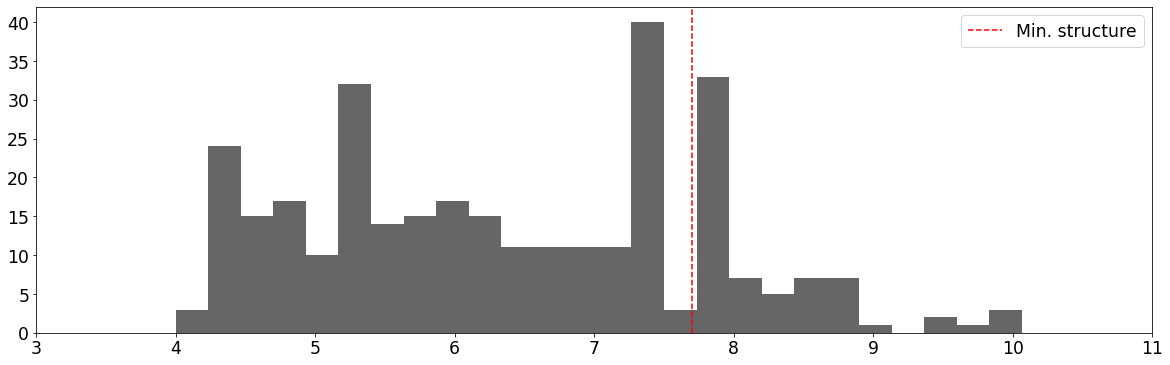

In [59]:
make_reward_hist(w6_train_reward, 6, min_e=46.2)

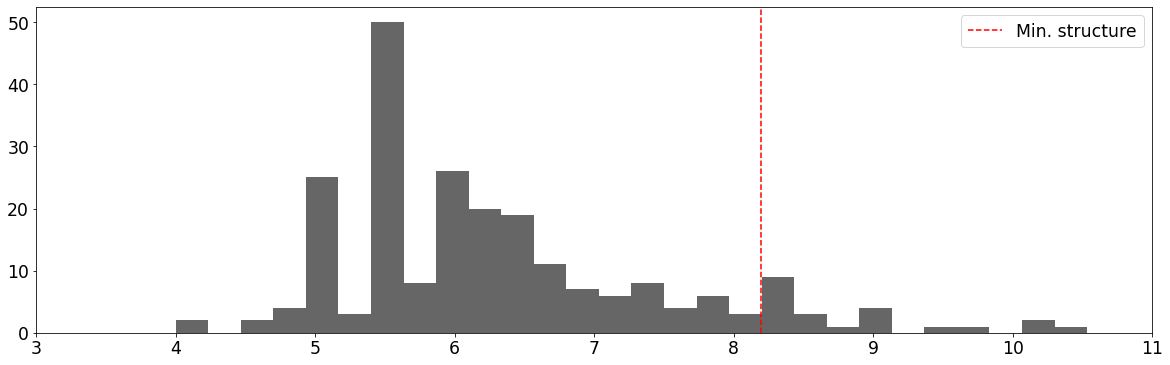

In [60]:
make_reward_hist(w7_train_reward, 7, min_e=57.37)

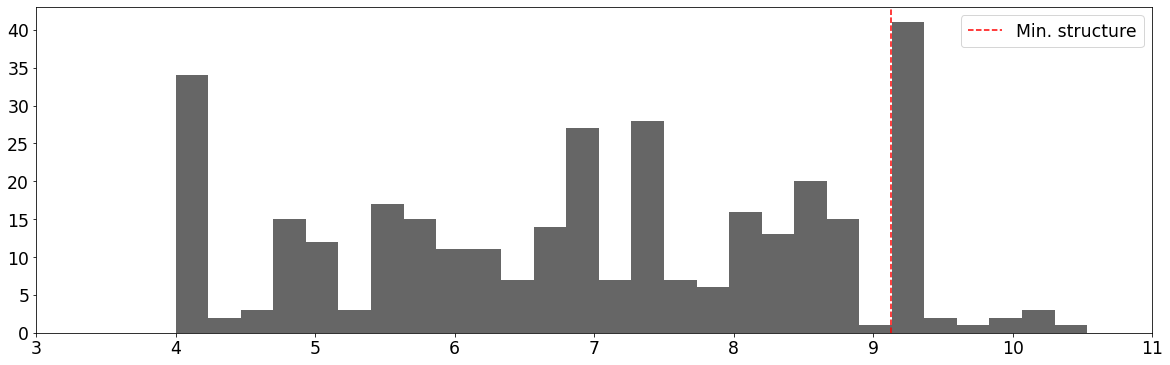

In [64]:
make_reward_hist(w8_train_reward, 8, min_e=73.0)

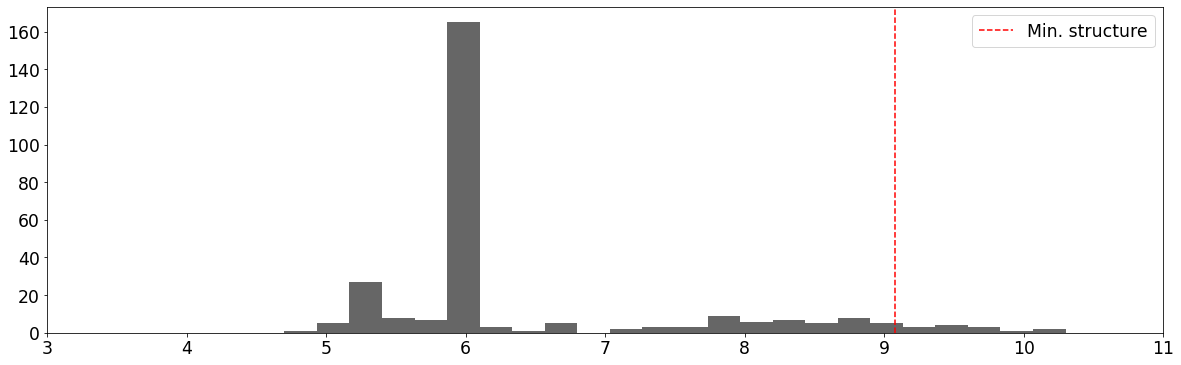

In [65]:
make_reward_hist(w9_train_reward, 9, min_e=81.70)

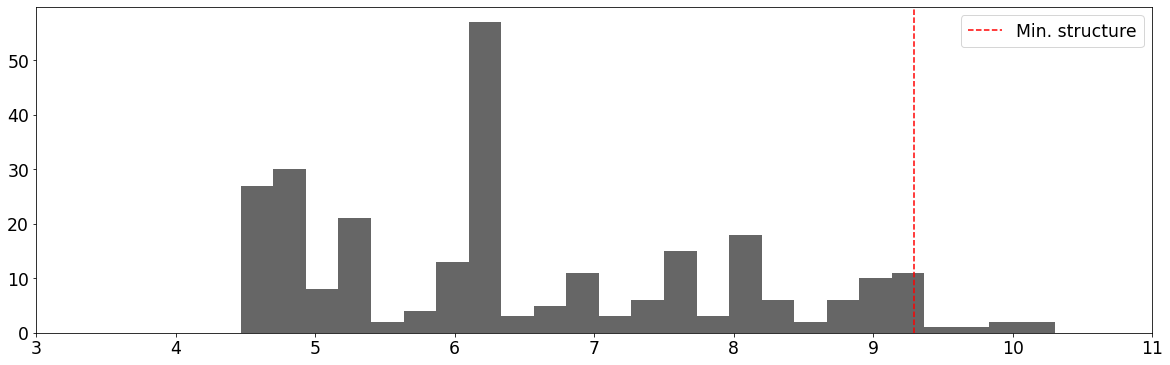

In [66]:
make_reward_hist(w10_train_reward, 10, min_e=92.89)

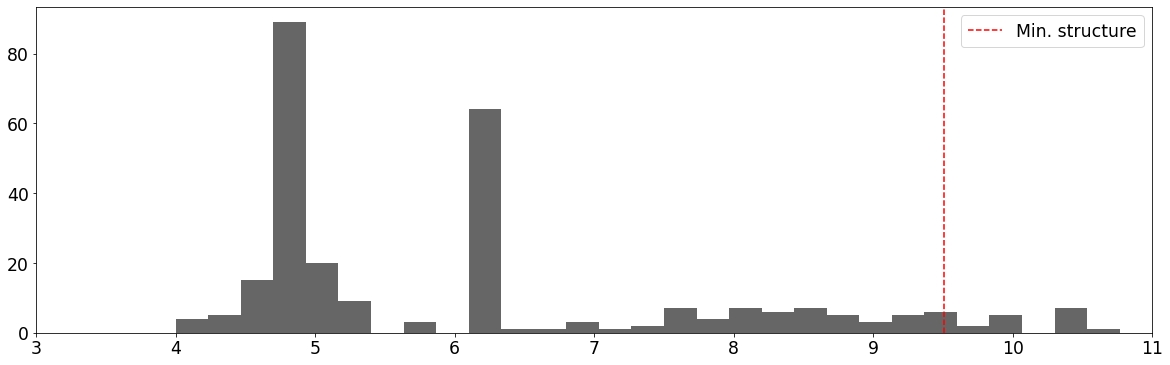

In [67]:
make_reward_hist(w11_train_reward, 11, min_e=104.6)

No handles with labels found to put in legend.


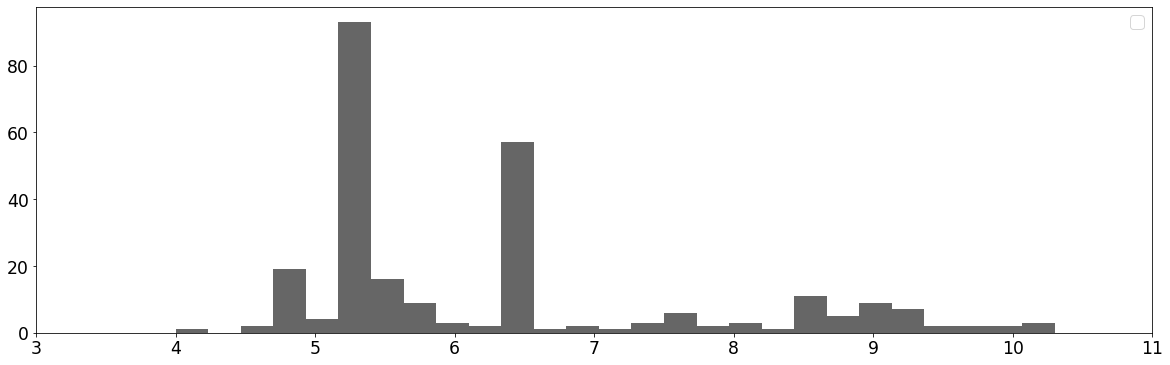

In [68]:
make_reward_hist(w12_train_reward, 12)

No handles with labels found to put in legend.


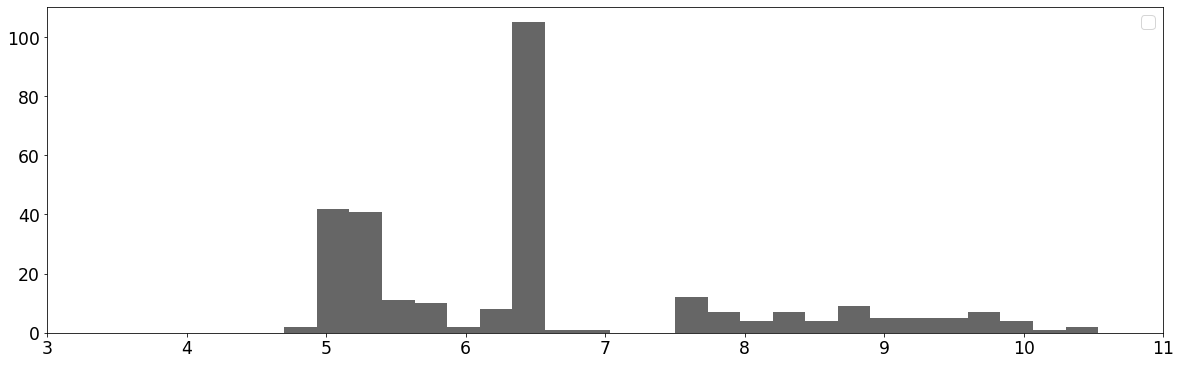

In [69]:
make_reward_hist(w13_train_reward, 13)

No handles with labels found to put in legend.


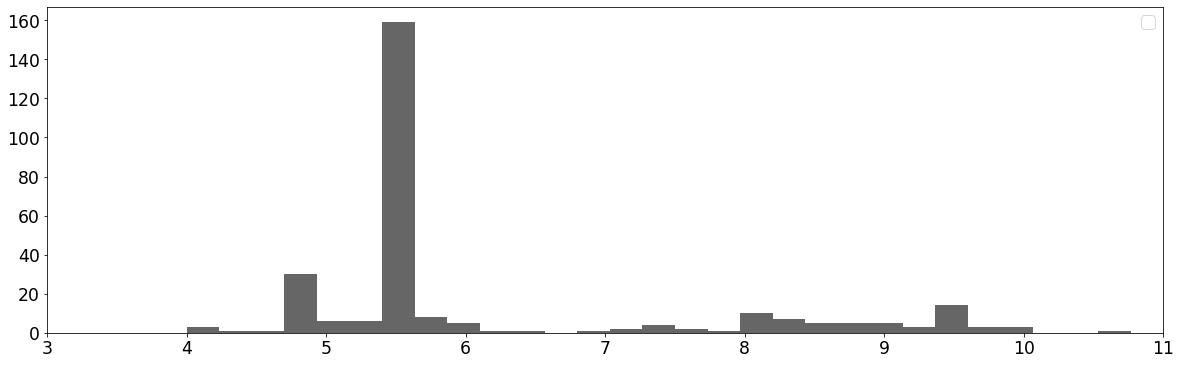

In [70]:
make_reward_hist(w14_train_reward, 14)

No handles with labels found to put in legend.


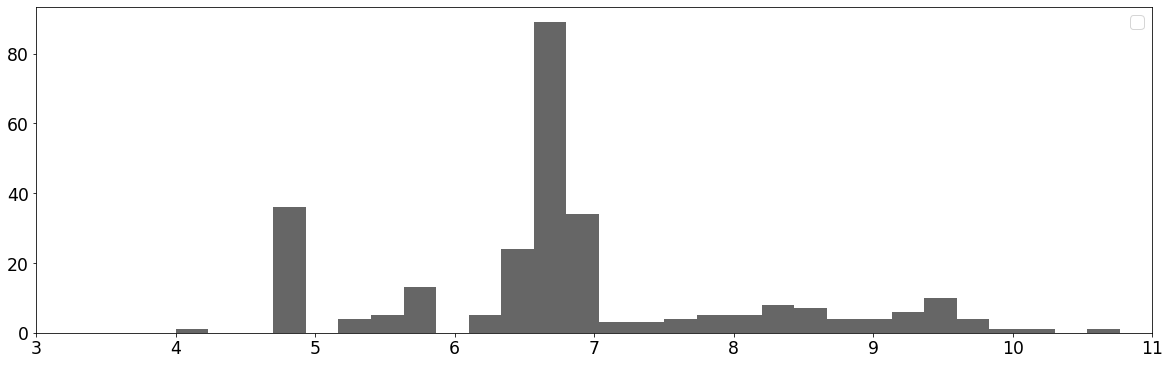

In [71]:
make_reward_hist(w15_train_reward, 15)

In [79]:
# Get graphs and corresponding predicted energies that are predicted to be MORE STABLE than the abs min
atom_s6, bond_s6, connectivity_s6, reward_s6 = get_stable_graphs('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W6-210122_221109-ee5482/training-structures.json', 46.2)

### Get cycle counts for all graphs explored during training and plot

In [21]:
# Get arrays of cycle counts for each cluster found during training
cycle3_6, cycle4_6, cycle5_6, cycle6_6 = get_cycle_counts(connectivity6)
cycle3_7, cycle4_7, cycle5_7, cycle6_7 = get_cycle_counts(connectivity7)
cycle3_8, cycle4_8, cycle5_8, cycle6_8 = get_cycle_counts(connectivity8)
cycle3_9, cycle4_9, cycle5_9, cycle6_9 = get_cycle_counts(connectivity9)
cycle3_10, cycle4_10, cycle5_10, cycle6_10 = get_cycle_counts(connectivity10)
cycle3_11, cycle4_11, cycle5_11, cycle6_11 = get_cycle_counts(connectivity11)
cycle3_12, cycle4_12, cycle5_12, cycle6_12 = get_cycle_counts(connectivity12)
cycle3_13, cycle4_13, cycle5_13, cycle6_13 = get_cycle_counts(connectivity13)
cycle3_14, cycle4_14, cycle5_14, cycle6_14 = get_cycle_counts(connectivity14)
cycle3_15, cycle4_15, cycle5_15, cycle6_15 = get_cycle_counts(connectivity15)

Text(0, 0.5, 'Number of 3-cycles per cluster')

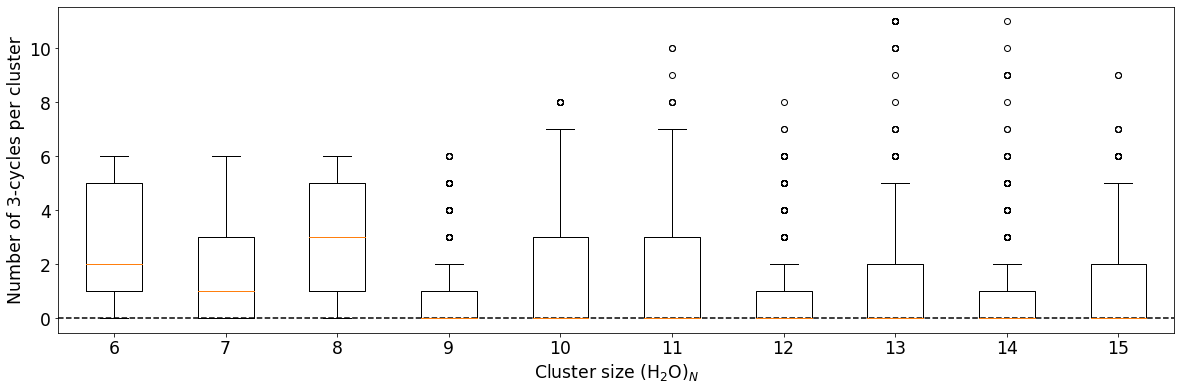

In [41]:
cluster_sizes = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.boxplot([cycle3_6, cycle3_7, cycle3_8, cycle3_9, cycle3_10, cycle3_11, cycle3_12, cycle3_13, cycle3_14, cycle3_15])
plt.axhline(y=0, linestyle='--', color='k')
plt.yticks(fontsize='xx-large')
plt.xticks([1,2,3,4,5,6,7,8,9,10], cluster_sizes, fontsize='xx-large')
plt.xlabel('Cluster size (H$_2$O)$_N$', fontsize='xx-large')
plt.ylabel('Number of 3-cycles per cluster', fontsize='xx-large')

Text(0, 0.5, 'Number of 4-cycles per cluster')

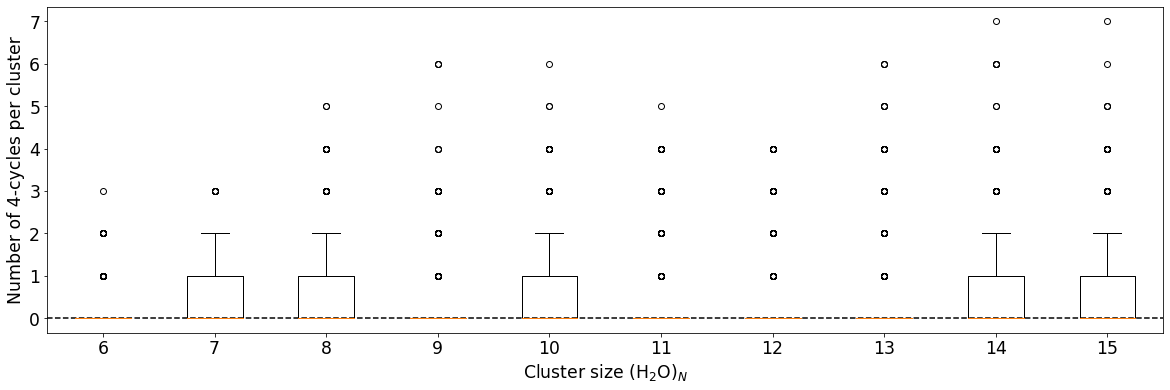

In [42]:
cluster_sizes = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.boxplot([cycle4_6, cycle4_7, cycle4_8, cycle4_9, cycle4_10, cycle4_11, cycle4_12, cycle4_13, cycle4_14, cycle4_15])
plt.axhline(y=0, linestyle='--', color='k')
plt.yticks(fontsize='xx-large')
plt.xticks([1,2,3,4,5,6,7,8,9,10], cluster_sizes, fontsize='xx-large')
plt.xlabel('Cluster size (H$_2$O)$_N$', fontsize='xx-large')
plt.ylabel('Number of 4-cycles per cluster', fontsize='xx-large')

Text(0, 0.5, 'Number of 5-cycles per cluster')

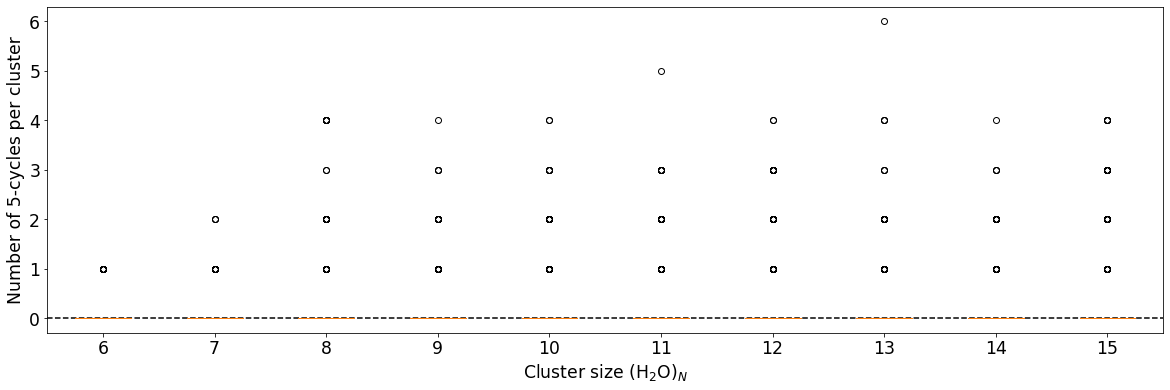

In [43]:
cluster_sizes = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.boxplot([cycle5_6, cycle5_7, cycle5_8, cycle5_9, cycle5_10, cycle5_11, cycle5_12, cycle5_13, cycle5_14, cycle5_15])
plt.axhline(y=0, linestyle='--', color='k')
plt.yticks(fontsize='xx-large')
plt.xticks([1,2,3,4,5,6,7,8,9,10], cluster_sizes, fontsize='xx-large')
plt.xlabel('Cluster size (H$_2$O)$_N$', fontsize='xx-large')
plt.ylabel('Number of 5-cycles per cluster', fontsize='xx-large')

Text(0, 0.5, 'Number of 6-cycles per cluster')

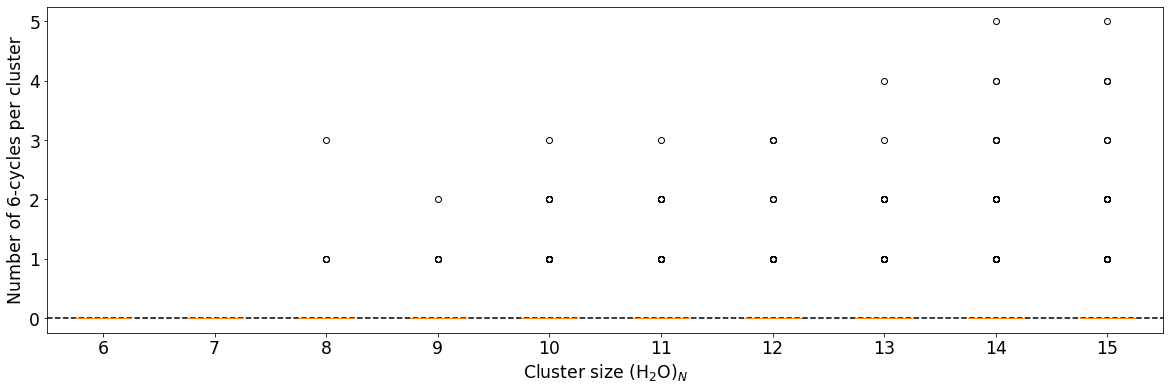

In [44]:
cluster_sizes = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.boxplot([cycle6_6, cycle6_7, cycle6_8, cycle6_9, cycle6_10, cycle6_11, cycle6_12, cycle6_13, cycle6_14, cycle6_15])
plt.axhline(y=0, linestyle='--', color='k')
plt.yticks(fontsize='xx-large')
plt.xticks([1,2,3,4,5,6,7,8,9,10], cluster_sizes, fontsize='xx-large')
plt.xlabel('Cluster size (H$_2$O)$_N$', fontsize='xx-large')
plt.ylabel('Number of 6-cycles per cluster', fontsize='xx-large')

### Get degree count for each water cluster explored during training and plot

In [22]:
# Get arrays of degree counts for each cluster found during training
d1_6, d2_6, d3_6, d4_6 = get_degrees(connectivity6)
d1_7, d2_7, d3_7, d4_7 = get_degrees(connectivity7)
d1_8, d2_8, d3_8, d4_8 = get_degrees(connectivity8)
d1_9, d2_9, d3_9, d4_9 = get_degrees(connectivity9)
d1_10, d2_10, d3_10, d4_10 = get_degrees(connectivity10)
d1_11, d2_11, d3_11, d4_11 = get_degrees(connectivity11)
d1_12, d2_12, d3_12, d4_12 = get_degrees(connectivity12)
d1_13, d2_13, d3_13, d4_13 = get_degrees(connectivity13)
d1_14, d2_14, d3_14, d4_14 = get_degrees(connectivity14)
d1_15, d2_15, d3_15, d4_15 = get_degrees(connectivity15)

In [24]:
# Compute average degree per cluster for all clusters found during training
d_6 = (d1_6 + d2_6*2 + d3_6*3 + d4_6*4)/6
d_7 = (d1_7 + d2_7*2 + d3_7*3 + d4_7*4)/7
d_8 = (d1_8 + d2_8*2 + d3_8*3 + d4_8*4)/8
d_9 = (d1_9 + d2_9*2 + d3_9*3 + d4_9*4)/9
d_10 = (d1_10 + d2_10*2 + d3_10*3 + d4_10*4)/10
d_11 = (d1_11 + d2_11*2 + d3_11*3 + d4_11*4)/11
d_12 = (d1_12 + d2_12*2 + d3_12*3 + d4_12*4)/12
d_13 = (d1_13 + d2_13*2 + d3_13*3 + d4_13*4)/13
d_14 = (d1_14 + d2_14*2 + d3_14*3 + d4_14*4)/14
d_15 = (d1_15 + d2_15*2 + d3_15*3 + d4_15*4)/15

Text(0, 0.5, 'Average coordination number')

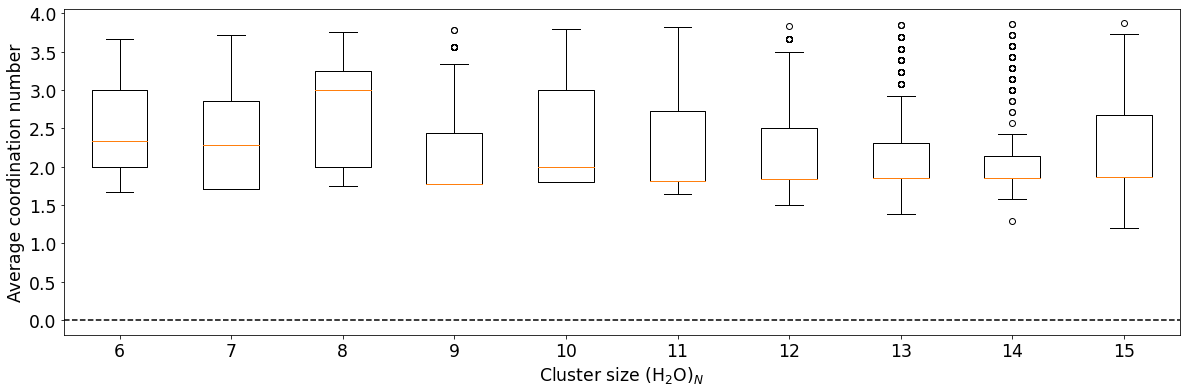

In [45]:
cluster_sizes = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.boxplot([d_6, d_7, d_8, d_9, d_10, d_11, d_12, d_13, d_14, d_15])
plt.axhline(y=0, linestyle='--', color='k')
plt.yticks(fontsize='xx-large')
plt.xticks([1,2,3,4,5,6,7,8,9,10], cluster_sizes, fontsize='xx-large')
plt.xlabel('Cluster size (H$_2$O)$_N$', fontsize='xx-large')
plt.ylabel('Average coordination number', fontsize='xx-large')

Text(0, 0.5, 'Number of 4-coordinated\nwater molecules per cluster')

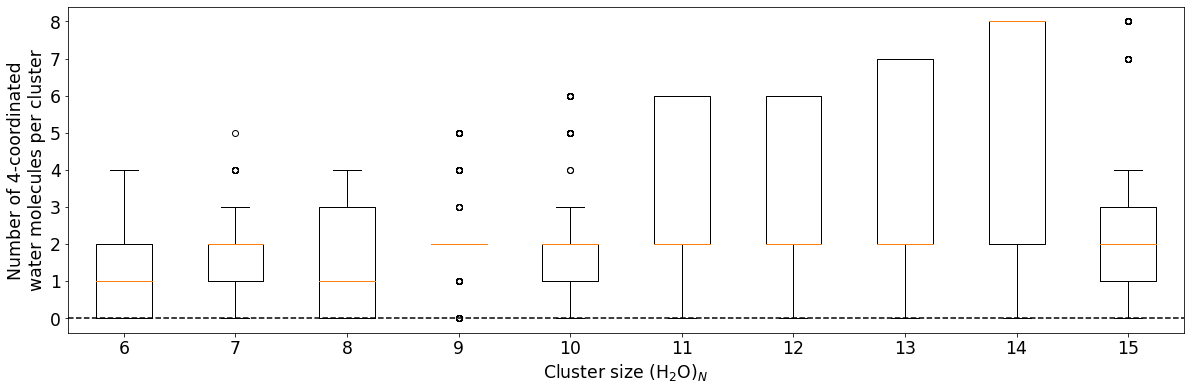

In [46]:
cluster_sizes = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.boxplot([d1_6, d1_7, d1_8, d1_9, d1_10, d1_11, d1_12, d1_13, d1_14, d1_15])
plt.axhline(y=0, linestyle='--', color='k')
plt.yticks(fontsize='xx-large')
plt.xticks([1,2,3,4,5,6,7,8,9,10], cluster_sizes, fontsize='xx-large')
plt.xlabel('Cluster size (H$_2$O)$_N$', fontsize='xx-large')
plt.ylabel('Number of 4-coordinated\nwater molecules per cluster', fontsize='xx-large')

Text(0, 0.5, 'Number of 4-coordinated\nwater molecules per cluster')

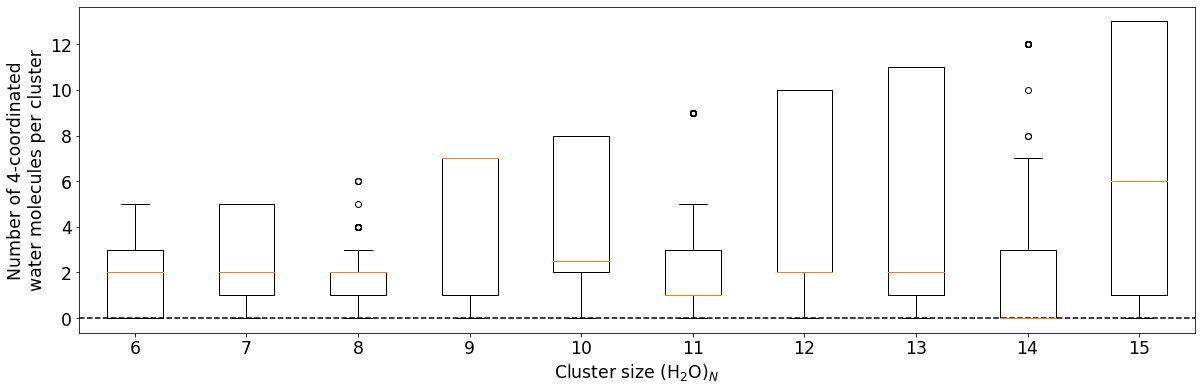

In [47]:
cluster_sizes = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.boxplot([d2_6, d2_7, d2_8, d2_9, d2_10, d2_11, d2_12, d2_13, d2_14, d2_15])
plt.axhline(y=0, linestyle='--', color='k')
plt.yticks(fontsize='xx-large')
plt.xticks([1,2,3,4,5,6,7,8,9,10], cluster_sizes, fontsize='xx-large')
plt.xlabel('Cluster size (H$_2$O)$_N$', fontsize='xx-large')
plt.ylabel('Number of 4-coordinated\nwater molecules per cluster', fontsize='xx-large')

Text(0, 0.5, 'Number of 4-coordinated\nwater molecules per cluster')

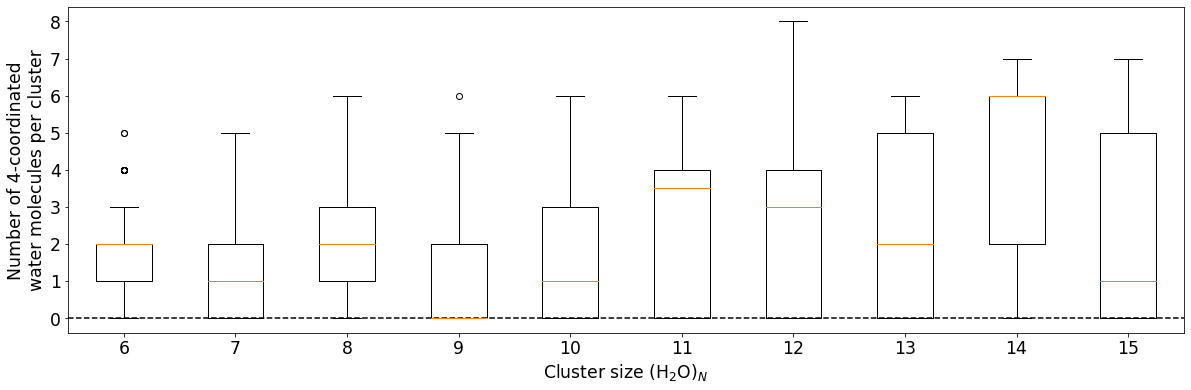

In [48]:
cluster_sizes = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.boxplot([d3_6, d3_7, d3_8, d3_9, d3_10, d3_11, d3_12, d3_13, d3_14, d3_15])
plt.axhline(y=0, linestyle='--', color='k')
plt.yticks(fontsize='xx-large')
plt.xticks([1,2,3,4,5,6,7,8,9,10], cluster_sizes, fontsize='xx-large')
plt.xlabel('Cluster size (H$_2$O)$_N$', fontsize='xx-large')
plt.ylabel('Number of 4-coordinated\nwater molecules per cluster', fontsize='xx-large')

Text(0, 0.5, 'Number of 4-coordinated\nwater molecules per cluster')

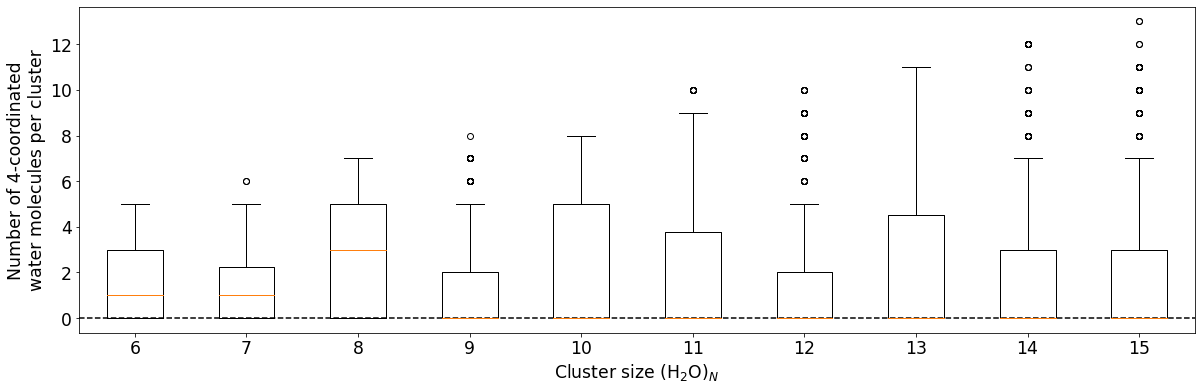

In [49]:
cluster_sizes = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.boxplot([d4_6, d4_7, d4_8, d4_9, d4_10, d4_11, d4_12, d4_13, d4_14, d4_15])
plt.axhline(y=0, linestyle='--', color='k')
plt.yticks(fontsize='xx-large')
plt.xticks([1,2,3,4,5,6,7,8,9,10], cluster_sizes, fontsize='xx-large')
plt.xlabel('Cluster size (H$_2$O)$_N$', fontsize='xx-large')
plt.ylabel('Number of 4-coordinated\nwater molecules per cluster', fontsize='xx-large')

### Find non-isomorphic graphs and plot fraction of graphs explored that are non-isomorphic (directed and undirected)

In [51]:
connect_list = [connectivity6, connectivity7, connectivity8, connectivity9, connectivity10, connectivity11, connectivity12, connectivity13, connectivity14, connectivity15]
bond_list = [bonds6, bonds7, bonds8, bonds9, bonds10, bonds11, bonds12, bonds13, bonds14, bonds15]
num_graphs = np.zeros(len(connect_list))
num_direct_graphs = np.zeros(len(connect_list))
num_undirect_graphs = np.zeros(len(connect_list))
for i in range(len(connect_list)):
    num_graphs[i] = len(connect_list[i])
    direct_graph = get_isomorphism_directed(connect_list[i], bond_list[i])
    undirect_graph = get_isomorphism_undirected(connect_list[i])
    num_direct_graphs[i] = len(direct_graph)
    num_undirect_graphs[i] = len(undirect_graph)

Number of isomorphic directed graphs: 158
Fraction of graphs produced that are nonisomorphic: 0.4952978056426332


KeyboardInterrupt: 

In [ ]:
indices = np.arange(len(num_graphs))
plt.bar(indices, num_graphs, width=0.5, label='Total graphs of size N', alpha=0.9)
plt.bar(indices, num_direct_graphs, width=0.5, label='Non-isomorphic $directed$ graphs', alpha=0.9)
plt.bar(indices, num_undirect_graphs, width=0.5, label='Non-isomorphic $undirected$ graphs', alpha=0.9)
plt.ylim(0, 400)
plt.yticks(fontsize='xx-large')
plt.xticks(indices, [6, 7, 8, 9, 10, 11, 12, 13, 14, 15], fontsize='xx-large')
plt.xlabel('Cluster size (H$_2$O)$_N$', fontsize='xx-large')
plt.ylabel('Number of graphs', fontsize='xx-large')
plt.legend(fontsize='x-large')

## Analyzing pathways explored during training (training-structures.json)

In [2]:
def get_pathways_from_json(json_file, max_water):
    all_paths = []
    graph_path = []
    for line in open(json_file):
        if json.loads(line)['n_waters'] < max_water+1:
            G = nx.Graph()
            G.add_edges_from(json.loads(line)['connectivity'])
            graph_path.append(G)
        else:
            all_paths.append(graph_path)
            graph_path = []
            pass
    return all_paths

In [3]:
def get_digraphs_from_json(json_file, max_water):
    all_paths = []
    graph_path = []
    for line in open(json_file):
        if json.loads(line)['n_waters'] < max_water+1:
            G = nx.DiGraph()
            G.add_nodes_from(json.loads(line)['atom'])
            G.add_edges_from(json.loads(line)['connectivity'])
            graph_path.append(G)
        else:
            all_paths.append(graph_path)
            graph_path = []
            pass
    return all_paths

In [4]:
def get_nonisomorphic_graphs(train_paths, nonisomorph_graphs=[]):
    for i in range(len(train_paths)):
        for j in range(len(train_paths[i])):
            if len(nonisomorph_graphs) == 0:
                nonisomorph_graphs.append(train_paths[i][j])
            else:
                true_count = 0
                for k in range(len(nonisomorph_graphs)):
                    is_isomorph = nx.algorithms.is_isomorphic(train_paths[i][j], nonisomorph_graphs[k])
                    if is_isomorph == True:
                        true_count += 1
                        pass
                if true_count == 0:
                    nonisomorph_graphs.append(train_paths[i][j])
    return nonisomorph_graphs

In [5]:
def get_edges_pathway(train_paths, nonisomorph_list):
    connect_tuples = []
    for i in range(len(train_paths)):
        map_list = []
        for j in range(len(train_paths[i])):
            for k in range(len(nonisomorph_list)):
                is_isomorph = nx.algorithms.is_isomorphic(train_paths[i][j], nonisomorph_list[k])
                if is_isomorph == True:
                    map_list.append(k)
                else:
                    pass
        map_tuples = get_tuples_from_list(map_list)
        connect_tuples.append(map_tuples[0:])
    return connect_tuples

In [6]:
def get_tuples_from_list(connect_list):
    connect_tuples = []
    for i in range(len(connect_list)-1):
        connect_tuples.append(tuple([connect_list[i], connect_list[i+1]]))
    return connect_tuples

Still need to find a good way of plotting the pathways (tree-like)

## Analyzing inference trajectories (final_trajs.pkl)

In [20]:
# load pickle files containing info about inference trajectories
w6_file = open('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W6-210122_221109-ee5482/final_trajs.pkl', 'rb')
w7_file = open('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W7-210122_224234-a7a5aa/final_trajs.pkl', 'rb')
w8_file = open('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W8-270122_014403-b2fe38/final_trajs.pkl', 'rb')
w9_file = open('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W9-270122_014403-feca8c/final_trajs.pkl', 'rb')
w10_file = open('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W10-270122_034036-06808c/final_trajs.pkl', 'rb')
#w10_new_file = open('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W10-010222_191913-6b5a50/final_trajs.pkl', 'rb')
w11_file = open('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W11-270122_034041-262235/final_trajs.pkl', 'rb')
w12_file = open('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W12-270122_034041-3f4a89/final_trajs.pkl', 'rb')
w13_file = open('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W13-270122_203702-9832e6/final_trajs.pkl', 'rb')
w14_file = open('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W14-270122_203702-21f529/final_trajs.pkl', 'rb')
w15_file = open('./hydronet/challenge-3/rl/runs/mpnn_last/mpnn_last-W15-270122_203703-b758d1/final_trajs.pkl', 'rb')
final_trajs6 = pickle.load(w6_file)
final_trajs7 = pickle.load(w7_file)
final_trajs8 = pickle.load(w8_file)
final_trajs9 = pickle.load(w9_file)
final_trajs10 = pickle.load(w10_file)
#final_trajs10_new = pickle.load(w10_new_file)
final_trajs11 = pickle.load(w11_file)
final_trajs12 = pickle.load(w12_file)
final_trajs13 = pickle.load(w13_file)
final_trajs14 = pickle.load(w14_file)
final_trajs15 = pickle.load(w15_file)

In [52]:
def get_nonisomorphs_from_pkl(inf_paths, inf_energies, inf_sizes, nonisomorph_graphs=[]):
    nonisomorph_energies = []
    nonisomorph_size = []
    for i in range(len(inf_paths)):
        for j in range(len(inf_paths[i])):
            if len(nonisomorph_graphs) == 0:
                nonisomorph_graphs.append(inf_paths[i][j])
                nonisomorph_energies.append(inf_energies[i][j])
                nonisomorph_size.append(inf_sizes[i][j])
            else:
                true_count = 0
                for k in range(len(nonisomorph_graphs)):
                    is_isomorph = nx.algorithms.is_isomorphic(inf_paths[i][j].to_undirected(), nonisomorph_graphs[k].to_undirected())
                    if is_isomorph == True:
                        true_count += 1
                        pass
                if true_count == 0:
                    nonisomorph_graphs.append(inf_paths[i][j])
                    nonisomorph_energies.append(inf_energies[i][j])
                    nonisomorph_size.append(inf_sizes[i][j])
    return nonisomorph_graphs, nonisomorph_energies, nonisomorph_size

In [72]:
def get_pathways_from_pkl(df, max_water):
    all_paths = []
    graph_path = []
    all_energies = []
    graph_energy = []
    all_sizes = []
    graph_size = []
    for i in range(len(df)):
        if int(df['size'].iloc[i]) < max_water+1:
            graph_path.append(df['graph'].iloc[i])
            graph_energy.append(df['energy'].iloc[i])
            graph_size.append(df['size'].iloc[i])
        else:
            all_paths.append(graph_path)
            all_energies.append(graph_energy)
            all_sizes.append(graph_size)
            graph_path = []
            graph_energy = []
            graph_size = []
            pass
    return all_paths, all_energies, all_sizes

In [73]:
# Get non-isomorphic directed graphs (and count) from inference trajs
post_traj_list = [final_trajs6, final_trajs7, final_trajs8, final_trajs9, final_trajs10, final_trajs11, final_trajs12, final_trajs13, final_trajs14, final_trajs15]
post_num_direct_graphs = np.zeros(len(post_traj_list))
post_num_undirect_graphs = np.zeros(len(post_traj_list))
post_num_graphs = np.zeros(len(post_traj_list))
for i in range(len(post_traj_list)):
    print(i)
    isomorphism_count = 0
    isomorphism_connect = []
    trajs = post_traj_list[i]
    ind = list(np.nonzero(np.array(trajs['reward']))[0])
    for j in range(0,len(ind)-1):
        true_count = 0
        for k in range(j+1, len(ind)):
            if nx.algorithms.is_isomorphic(trajs['graph'][ind[j]], trajs['graph'][ind[k]]) == True:
                true_count += 1
            else:
                pass
        if true_count == 0:
            isomorphism_connect.append(trajs['graph'][ind[j]])
    post_num_graphs[i] = len(ind)
    post_num_direct_graphs[i] = len(isomorphism_connect)

0
1
2


KeyboardInterrupt: 

In [30]:
# Get non-isomorphic undirected graphs (and count) from inference trajs
for i in range(len(post_traj_list)):
    print(i)
    isomorphism_count = 0
    isomorphism_connect = []
    trajs = post_traj_list[i]
    ind = list(np.nonzero(np.array(trajs['reward']))[0])
    for j in range(0,len(ind)-1):
        true_count = 0
        for k in range(j+1, len(ind)):
            if nx.algorithms.is_isomorphic(trajs['graph'][ind[j]].to_undirected(), trajs['graph'][ind[k]].to_undirected()) == True:
                true_count += 1
            else:
                pass
        if true_count == 0:
            isomorphism_connect.append(trajs['graph'][ind[j]].to_undirected())
    post_num_undirect_graphs[i] = len(isomorphism_connect)

0


KeyboardInterrupt: 

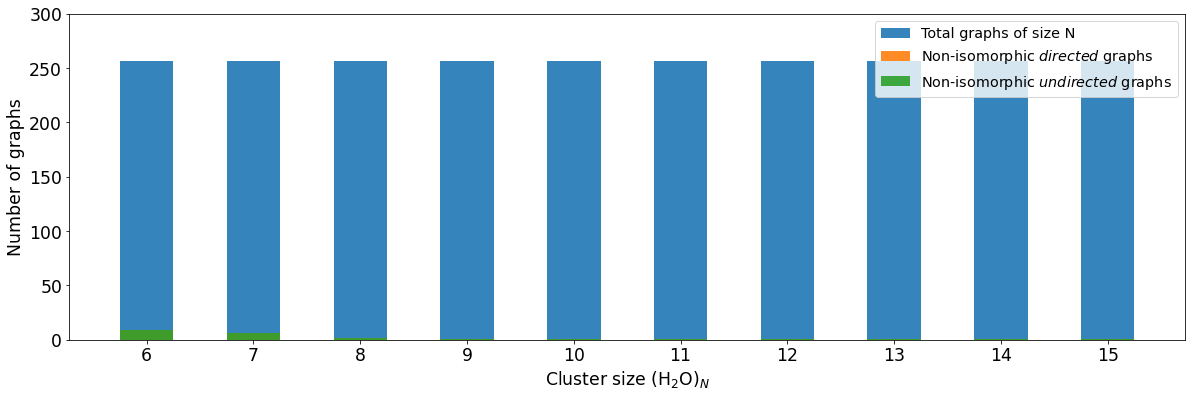

In [81]:
indices = np.arange(len(post_traj_list))
plt.bar(indices, post_num_graphs, width=0.5, label='Total graphs of size N', alpha=0.9)
plt.bar(indices, post_num_direct_graphs+1, width=0.5, label='Non-isomorphic $directed$ graphs', alpha=0.9)
plt.bar(indices, post_num_undirect_graphs+1, width=0.5, label='Non-isomorphic $undirected$ graphs', alpha=0.9)
plt.ylim(0, 300)
plt.yticks(fontsize='xx-large')
plt.xticks(indices, [6, 7, 8, 9, 10, 11, 12, 13, 14, 15], fontsize='xx-large')
plt.xlabel('Cluster size (H$_2$O)$_N$', fontsize='xx-large')
plt.ylabel('Number of graphs', fontsize='xx-large')
plt.legend(fontsize='x-large')

In [80]:
w6_inf_paths, w6_inf_energies, w6_inf_sizes = get_pathways_from_pkl(final_trajs6, 6)
w7_inf_paths, w7_inf_energies, w7_inf_sizes = get_pathways_from_pkl(final_trajs7, 7)
w8_inf_paths, w8_inf_energies, w8_inf_sizes = get_pathways_from_pkl(final_trajs8, 8)
w9_inf_paths, w9_inf_energies, w9_inf_sizes = get_pathways_from_pkl(final_trajs9, 9)
w10_inf_paths, w10_inf_energies, w10_inf_sizes = get_pathways_from_pkl(final_trajs10, 10)